In [53]:
# Very Helpful link
# https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html

In [66]:
# Makes File Handling Easier
import os

# PyTorch model and training necessities
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# from torch.utils.data import DataLoader

# Image datasets and image manipulation
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.io import read_image
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd

# Image display
import matplotlib.pyplot as plt
import numpy as np

# PyTorch TensorBoard support
from torch.utils.tensorboard.writer import SummaryWriter

# ? Not sure what these are for
import scipy.io as scio
import shutil

In [67]:
# Create train, valid and test directories to sort dataset into.
def makePartitionDirs():
    for i in range(1, 103):
        os.makedirs("data/102flowers/train/" + str(i), exist_ok=True)
        os.makedirs("data/102flowers/test/" + str(i), exist_ok=True)
        os.makedirs("data/102flowers/valid/" + str(i), exist_ok=True)


# Distribute dataset into train, valid and test directories according to setid.mat specifications.
def partitionData(imageLabels, setid, sortedPath, dataPath):
    for i in range(len(imageLabels["labels"][0])):
        filename = "image_" + str(i + 1).zfill(5) + ".jpg"
        if i + 1 in setid["trnid"][0]:
            targetFolder = os.path.join(
                sortedPath, "train", str(imageLabels["labels"][0][i])
            )
        elif i + 1 in setid["valid"][0]:
            targetFolder = os.path.join(
                sortedPath, "valid", str(imageLabels["labels"][0][i])
            )
        else:
            targetFolder = os.path.join(
                sortedPath, "test", str(imageLabels["labels"][0][i])
            )
        shutil.copy(
            os.path.join(dataPath, filename), os.path.join(targetFolder, filename)
        )

In [68]:
trainTransforms = transforms.Compose(
    [
        transforms.Resize(160),
        transforms.RandomRotation(90),
        transforms.CenterCrop(128),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)
testTransforms = validTransforms = transforms.Compose(
    [
        transforms.Resize(160),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

In [69]:
dataPath = "data/102flowers/jpg"
sortedPath = "data/102flowers"
setid = scio.loadmat(f"data/setid.mat")
imageLabels: dict = scio.loadmat(f"data/imagelabels.mat")
# Call these if you don't have the directories set up as needed.
makePartitionDirs()
partitionData(imageLabels, setid, sortedPath, dataPath)
trainingData = datasets.ImageFolder(
    root="data/102flowers/train", transform=trainTransforms
)
validationData = datasets.ImageFolder(
    root="data/102flowers/valid", transform=validTransforms
)
testingData = datasets.ImageFolder(
    root="data/102flowers/test", transform=testTransforms
)

In [70]:
# Data loaders for use as input.
in_batch_size = 16
trainDataLoader = torch.utils.data.DataLoader(
    trainingData, batch_size=in_batch_size, shuffle=True
)
validDataLoader = torch.utils.data.DataLoader(
    validationData, batch_size=in_batch_size, shuffle=False
)
testDataLoader = torch.utils.data.DataLoader(
    testingData, batch_size=in_batch_size, shuffle=False
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4
tensor([44, 38, 82, 86])


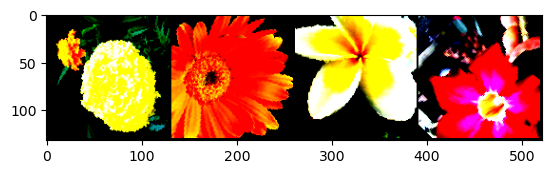

44 38 82 86


In [85]:
def showImage(image):
    npImage = image.numpy()
    plt.imshow(np.transpose(npImage, (1, 2, 0)))
    plt.show()


torch.manual_seed(12345)
dataIter = iter(trainDataLoader)
images, labels = next(dataIter)
print(len(images))
print(labels)
showImage(torchvision.utils.make_grid(images))
print(" ".join(f"{labels[j]}" for j in range(4)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 100, 100])
torch.Size([3, 100, 100])
torch.Size([3, 100, 100])
torch.Size([3, 100, 100])
torch.Size([3, 100, 100])
torch.Size([3, 100, 100])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 100, 100])
torch.Size([3, 100, 100])
torch.Size([3, 100, 100])


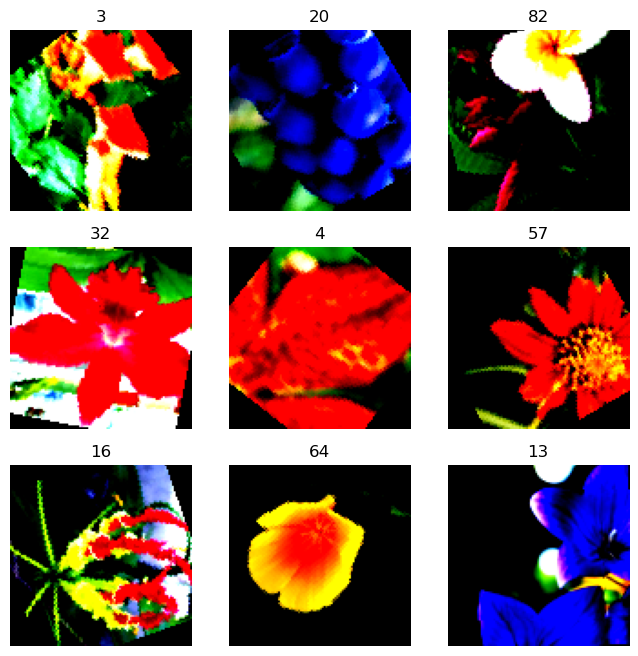

In [65]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(trainingData), size=(1,)).item()
    img, label = trainingData[int(sample_idx)]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    print(img.squeeze().shape)
    processed_image = np.rollaxis(img.squeeze().numpy(), 0, 3)
    plt.imshow(processed_image)
plt.show()

In [86]:
# The CNN Network
class Net(nn.Module):
    def __init__(self, img_size=256):
        super(Net, self).__init__()
        self.img_size = img_size
        # 3 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(3, 6, img_size)
        self.conv2 = nn.Conv2d(6, 16, img_size)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * img_size**2, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # # Max pooling over a (2, 2) window
        # x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), self.img_size)
        x = torch.flatten(x, 1)  # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
net

Net(
  (conv1): Conv2d(3, 6, kernel_size=(256, 256), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(256, 256), stride=(1, 1))
  (fc1): Linear(in_features=1048576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
# See the learnable parameters of our model
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

In [ ]:
# Generate a random 32x32 image, what the models wants
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)

In [ ]:
# Zero the gradient buffers of all parameters and backprops with random gradients
net.zero_grad()
out.backward(torch.randn(1, 10))

In [ ]:
# Does this device have a GPU?
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

# Use the GPU if its there, otherwise use the CPU
net.to(device)

In [ ]:
# Loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# Train the Network
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainDataLoader, 0):
        # Get the inputs; data is a list of [inputs, labels] # inputs, labels = data
        # And send all the inputs and targets at every step to the chosen device
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)  # This is the Forward Pass
        loss = criterion(outputs, labels)
        loss.backward()  # This is the Backward Pass
        optimizer.step()  # This is the optimizer

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:  # print every 2000 mini-batches
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}")
            running_loss = 0.0

print("Finished Training")

In [ ]:
# Save the trained network
PATH = "./flowers102.pth"
torch.save(net.state_dict(), PATH)

In [ ]:
# Test the network
dataiter = iter(testDataLoader)
images, labels = next(dataiter)

# print images
plt.imshow(torchvision.utils.make_grid(images))
print("GroundTruth: ", " ".join(f"{labels[j]:5s}" for j in range(4)))

In [ ]:
# Load back the saved network
net = Net()
net.load_state_dict(torch.load(PATH))

In [ ]:
# Get predictions
outputs = net(images)

In [ ]:
# Lets get the images which the AI thinks is the strongest case of each class
_, predicted = torch.max(outputs, 1)

print("Predicted: ", " ".join(f"{predicted[j]:5s}" for j in range(4)))

In [ ]:
# Gauge the performance of the network
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testDataLoader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the network on the 10000 test images: {100 * correct // total} %")

In [ ]:
# Get the predictions accuracy of each class

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in labels}
total_pred = {classname: 0 for classname in labels}

# again no gradients needed
with torch.no_grad():
    for data in testDataLoader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[label] += 1
            total_pred[label] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f"Accuracy for class: {classname:5s} is {accuracy:.1f} %")

In [ ]:
# Cleanup
del dataiter